In [ ]:
pip install patchify

Getting the dataset from a remote location

In [ ]:
!git clone https://github.com/zahid008/satellite-Image-Segmentation-Dataset.git

fatal: destination path 'satellite-Image-Segmentation-Dataset' already exists and is not an empty directory.


#### Importing Necessary Libraries

In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler

#### Exploring the dataset

In [95]:
link = '/content/satellite-Image-Segmentation-Dataset/Semantic segmentation dataset'

In [97]:
for path, subdirs, file in os.walk(link):
    dir_names = path.split(os.path.sep)[-1]
    #print(dir_names)
    if dir_names == 'images':
        images = os.listdir(path)
        #print(images)

(644, 797, 3)


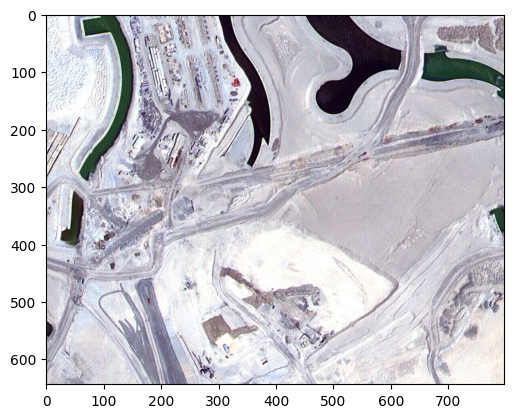

In [125]:
image_part_001 = cv2.imread(f'{link}/Tile 1/images/image_part_001.jpg',1)
print(image_part_001.shape)
image_part_001_rgb = cv2.cvtColor(image_part_001, cv2.COLOR_BGR2RGB)
plt.imshow(image_part_001_rgb)

This code reads the image with OpenCV, converts it from BGR to RGB (since OpenCV uses BGR by default, but matplotlib expects RGB), and then displays it using matplotlib.

#### patchify

In [99]:
patch_size = 256
scaler = MinMaxScaler()

In [141]:
def prepare_dataset(image_type, image_extension):
  dataset = []

  for tile_id in range(1,9):
    for image_id in range(1,10):
      image = cv2.imread(f'{link}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      #print('before croping:' ,image.shape)

      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #creating the row and column size for each image for patchifying
        size_x = (image.shape[1]//patch_size)*patch_size
        size_y= (image.shape[0]//patch_size)*patch_size

        image = Image.fromarray(image)
        image = image.crop((0,0,size_x,size_y))


        image = np.asarray(image)
        #print('after croping:',image.shape)
        patched_images = patchify(image,(patch_size,patch_size,3), step = patch_size)
        #print('patched image: ',patched_images.shape)

        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_image = patched_images[i,j,:,:]
              #print('Individual image from patch: ', individual_image.shape)
              scaled_image = scaler.fit_transform(individual_image.reshape(-1,individual_image.shape[-1])).reshape(individual_image.shape)
              #print('scaled image: ',scaled_image.shape)
              dataset.append(scaled_image[0])

            elif image_type == 'masks':
              individual_mask = patched_images[i,j,:,:]
              individual_mask = individual_mask[0]
              dataset.append(individual_mask)
  return dataset

In [142]:
image_dataset = prepare_dataset('images','jpg')
mask_dataset = prepare_dataset('masks', 'png')

In [102]:
print(len(image_dataset))
print(len(mask_dataset))

1305
1305


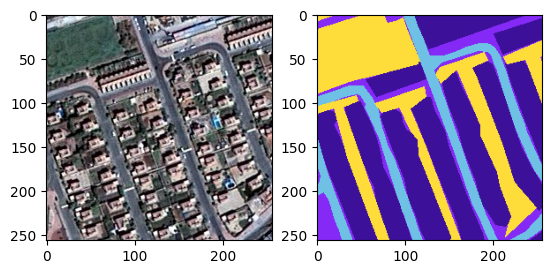

In [103]:
random_number = np.random.randint(0,len(image_dataset))
plt.subplot(121)
plt.imshow(image_dataset[random_number])
plt.subplot(122)
plt.imshow(mask_dataset[random_number])

In [106]:
json_link = '/content/satellite-Image-Segmentation-Dataset/Semantic segmentation dataset/classes.json'

with open(json_link, 'r') as file:
  json_file = json.load(file)

json_file['classes']

[{'title': 'Water',
  'shape': 'polygon',
  'color': '#50E3C2',
  'geometry_config': {}},
 {'title': 'Land (unpaved area)',
  'shape': 'polygon',
  'color': '#F5A623',
  'geometry_config': {}},
 {'title': 'Road',
  'shape': 'polygon',
  'color': '#DE597F',
  'geometry_config': {}},
 {'title': 'Building',
  'shape': 'polygon',
  'color': '#D0021B',
  'geometry_config': {}},
 {'title': 'Vegetation',
  'shape': 'polygon',
  'color': '#417505',
  'geometry_config': {}},
 {'title': 'Unlabeled',
  'shape': 'polygon',
  'color': '#9B9B9B',
  'geometry_config': {}}]

In [124]:
def hex2int(class_label):
  class_label = class_label.lstrip('#')
  class_label = np.array(tuple(int(class_label[i:i+2], 16) for i in (0,2,4)))
  print(class_label)
  return class_label

class_building = hex2int('#3C1098')
class_land = hex2int('#8429F6')

class_road = hex2int('#6EC1E4')
class_vegetation  = hex2int('#FEDD3A')

class_water = hex2int('#E2A929')
class_unlabeled = hex2int('#9B9B9B')


[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]
